In [2]:
import pandas as pd
import os
from dotenv import load_dotenv
from openai import OpenAI

In [15]:
gpt3_count = 0
gpt4_count = 0

In [3]:
df = pd.read_csv("../data/li_chess_for_exp.csv", index_col=0) # relative path
df["explanation"] = ""
df.head()

,moves,explanation
0,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,
1,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,
2,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,
3,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,
4,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,


In [4]:
df.shape

(5000, 2)

In [5]:
load_dotenv()
openai_api_key = os.getenv("openai_api_key")

In [6]:
client = OpenAI(api_key=openai_api_key)

In [7]:
def gen_cot_prompt(prev_moves : str) -> str:
    prev_moves = prev_moves.split(" ")
    cot_moves = [f"White: {prev_moves[i]}, Black: {prev_moves[i+1]}" if i + 1 < len(prev_moves) else f"White: {prev_moves[i]}" for i in range(0, len(prev_moves), 2)]
    return "\n".join(cot_moves), len(cot_moves)

In [9]:
system_content_cot = '''
    Act as a chess master.
    You will be provided with a list of chess move pairs in Algebraic Notation where 1st move is by White and 2nd by Black.
    Generate a very concise rationale behind each pair of moves for all the pairs provided. make sure it fits your context window and you provide analysis for each pair.
    After the pair based analysis, you have to write a short summary on why the last move was taken, who is likely to be the winner and what strategy did the player use throughout the game.
    Use the heading for your answer: Game analysis, winner and summary of strategy.
    '''

In [10]:
gpt3 = "gpt-3.5-turbo-0125"
# oai_model = "gpt-4-turbo"
gpt4 = "gpt-4o"

In [17]:
def generate_explanation(client: OpenAI, model_name: list, df: pd.DataFrame, system_content: str, save_path: str, save_interval: int = 20) -> pd.DataFrame:
    return_df = df.copy()
    global gpt3_count, gpt4_count

    for i in range(df.shape[0]):
        print(f"[Info] Generating explanation for row {i}")
        moves = df.iloc[i]["moves"]

        user_prompt_move, context_length = gen_cot_prompt(moves)
        user_content_cot = f"Move pairs are - \n{user_prompt_move}"

        model = model_name[0] if context_length <= 20 else model_name[1]
        if model == model_name[0]:
            gpt3_count +=1
        else:
            gpt4_count += 1
        print(f"[Model-info] Using openai model {model}")
        
        stream = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content_cot}
            ],
            stream=True,
        )
        
        explanation = ""
        for chunk in stream:
            if chunk.choices[0].delta.content is not None:
                explanation += chunk.choices[0].delta.content
        return_df.loc[i, "explanation"] = explanation.strip()
        
        # saving file at each interval
        if (i + 1) % save_interval == 0:
            header = (i == 0)
            return_df.to_csv(save_path, mode="w", header=header, index=False)
            print(f"[Info] Saved progress as csv in {save_path} at iteration {i + 1}")

    # Save the final DataFrame after the loop
    print("[Info] Final data saved")
    return return_df


In [18]:
# for testing
temp = df.iloc[:20]

In [19]:
target_df = generate_explanation(OpenAI(api_key = openai_api_key), [gpt3, gpt4], temp, system_content_cot, "./interval_data/interval.csv", 5)
target_df.to_csv(f"../exp_data/lichess_exp.csv")
print("[Info] Final CSV generated")

[Info] Generating explanation for row 0
[Model-info] Using openai model gpt-3.5-turbo-0125
[Info] Generating explanation for row 1
[Model-info] Using openai model gpt-3.5-turbo-0125
[Info] Generating explanation for row 2
[Model-info] Using openai model gpt-4o
[Info] Generating explanation for row 3
[Model-info] Using openai model gpt-4o
[Info] Generating explanation for row 4
[Model-info] Using openai model gpt-4o
[Info] Saved progress as csv in ./interval_data/interval.csv at iteration 5
[Info] Generating explanation for row 5
[Model-info] Using openai model gpt-3.5-turbo-0125
[Info] Generating explanation for row 6
[Model-info] Using openai model gpt-3.5-turbo-0125
[Info] Generating explanation for row 7
[Model-info] Using openai model gpt-3.5-turbo-0125
[Info] Generating explanation for row 8
[Model-info] Using openai model gpt-4o
[Info] Generating explanation for row 9
[Model-info] Using openai model gpt-4o
[Info] Saved progress as csv in ./interval_data/interval.csv at iteration 

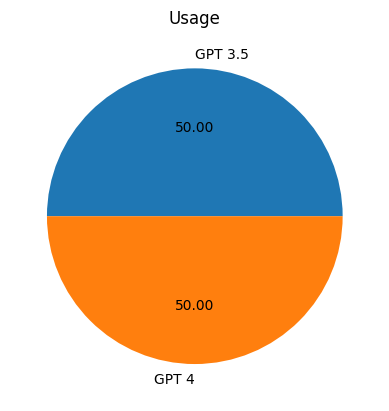

In [22]:
import matplotlib.pyplot as plt

data = ["GPT 3.5", "GPT 4"]
values = [gpt3_count, gpt4_count]

plt.pie(values, labels=data, autopct="%.2f")
plt.title("Usage for 20 rows")
plt.show()